In [ ]:
!pip install -q tensorflow pandas scikit-learn


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
import pandas as pd

try:
    # Try Colab upload (only works inside Google Colab)
    from google.colab import files
    uploaded = files.upload()
    df = pd.read_csv(next(iter(uploaded)))
except ImportError:
    # Running locally / GitHub Actions → read dataset from repo
    df = pd.read_csv("dataset_phishing.csv")

# Create a binary label but keep all other columns
df['label'] = df['status'].map({'phishing': 1, 'legitimate': 0})
print(df.head(20))


,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status,label
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,1,0,45,-1,0,1,1,4,legitimate,0
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,0,0,77,5767,0,0,1,2,phishing,1
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,0,0,14,4004,5828815,0,1,0,phishing,1
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,0,0,62,-1,107721,0,0,3,legitimate,0
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,1,0,224,8175,8725,0,0,6,legitimate,0
5,http://appleid.apple.com-app.es/,32,24,0,3,1,0,0,0,0,...,1,1,0,-1,0,0,1,0,phishing,1
6,http://www.mutuo.it,19,12,0,2,0,0,0,0,0,...,1,0,170,7529,0,0,0,1,legitimate,0
7,http://www.shadetreetechnology.com/V4/validati...,81,27,1,2,0,0,0,0,0,...,0,0,76,5767,0,0,1,2,phishing,1
8,http://vamoaestudiarmedicina.blogspot.com/,42,34,0,2,0,0,0,0,0,...,1,0,371,7298,0,0,0,5,legitimate,0
9,https://parade.com/425836/joshwigler/the-amazi...,104,10,0,1,10,0,0,0,0,...,0,0,128,9368,6774,0,0,5,legitimate,0


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Character-level tokenizer
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(df['url'])

# Convert URLs to sequences of character indices
sequences = tokenizer.texts_to_sequences(df['url'])

# Pad sequences
max_len = 200
X = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# Labels
y = df['label'].values


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Conv1D, GlobalMaxPooling1D, Dense, Dropout

model = Sequential([
    Input(shape=(max_len,)),
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32),

    # LSTM + CNN Hybrid Layers
    LSTM(64, return_sequences=True),             # Output shape: (batch, max_len, 64)
    Conv1D(filters=64, kernel_size=3, activation='relu'),  # Local pattern extraction
    GlobalMaxPooling1D(),                         # Reduces to (batch, 64)

    # Fully connected layers
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 32)        │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 200, 64)        │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 198, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,809 (171.13 KB)

 Trainable params: 43,809 (171.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    verbose=1
)


Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 24s 172ms/step - accuracy: 0.6039 - loss: 0.6670 - val_accuracy: 0.7736 - val_loss: 0.4884
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 21s 184ms/step - accuracy: 0.7701 - loss: 0.4927 - val_accuracy: 0.7829 - val_loss: 0.4583
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 45s 216ms/step - accuracy: 0.7838 - loss: 0.4621 - val_accuracy: 0.7890 - val_loss: 0.4314
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - accuracy: 0.8002 - loss: 0.4376 - val_accuracy: 0.8037 - val_loss: 0.3986
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 21s 183ms/step - accuracy: 0.8233 - loss: 0.4016 - val_accuracy: 0.8420 - val_loss: 0.3560
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 42s 192ms/step - accuracy: 0.8383 - loss: 0.3733 - val_accuracy: 0.8425 - val_loss: 0.3654
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 38s 168ms/step - accuracy: 0.8440 - loss: 0.3624 - val_accuracy: 0.8431 - val_loss: 0.3431
Epoch 8/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 23s 190ms/step - accuracy: 0.8474 - loss: 0

72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step
🔍 Evaluation Metrics:
Accuracy:           0.9038
Precision:          0.8811
Recall:             0.9335
F1 Score:           0.9065
Balanced Accuracy:  0.9038
Matthews Corrcoef:  0.8090
ROC AUC Score:      0.9706

📊 Confusion Matrix:
[[ 999  144]
 [  76 1067]]

📋 Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.93      0.87      0.90      1143
    Phishing       0.88      0.93      0.91      1143

    accuracy                           0.90      2286
   macro avg       0.91      0.90      0.90      2286
weighted avg       0.91      0.90      0.90      2286



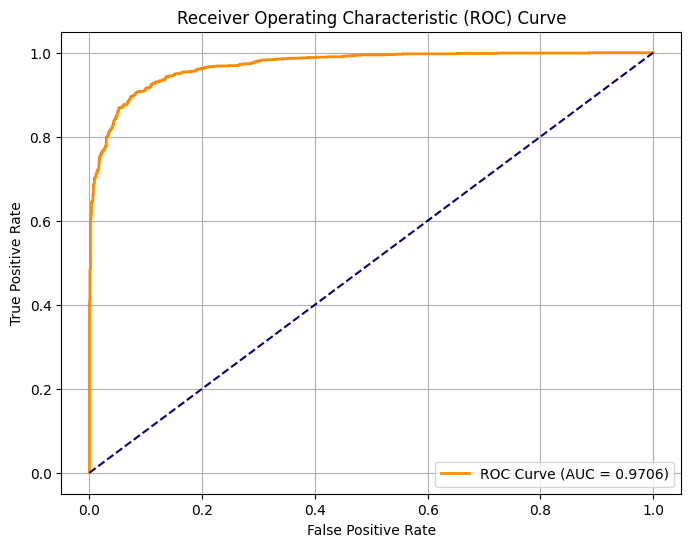

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, matthews_corrcoef,
    balanced_accuracy_score, roc_auc_score, roc_curve
)
import numpy as np
import matplotlib.pyplot as plt

# Predict probabilities
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Compute Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print Results
print("🔍 Evaluation Metrics:")
print(f"Accuracy:           {accuracy:.4f}")
print(f"Precision:          {precision:.4f}")
print(f"Recall:             {recall:.4f}")
print(f"F1 Score:           {f1:.4f}")
print(f"Balanced Accuracy:  {balanced_acc:.4f}")
print(f"Matthews Corrcoef:  {mcc:.4f}")
print(f"ROC AUC Score:      {auc:.4f}")
print("\n📊 Confusion Matrix:")
print(conf_matrix)

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Phishing']))

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


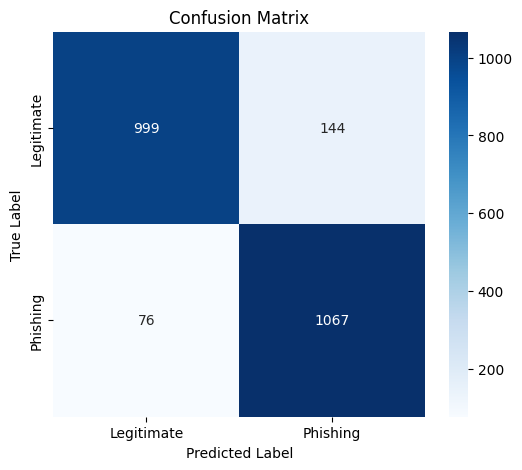

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion matrix values
cm = confusion_matrix(y_test, y_pred)
labels = ['Legitimate', 'Phishing']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


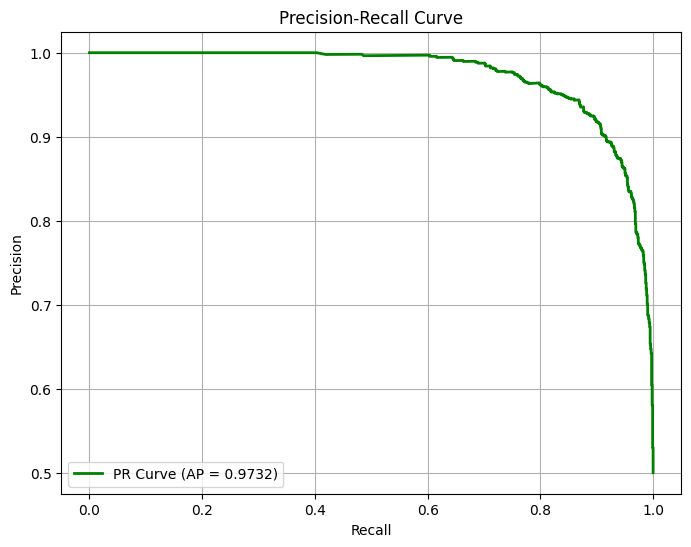

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
ap = average_precision_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2, label=f'PR Curve (AP = {ap:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


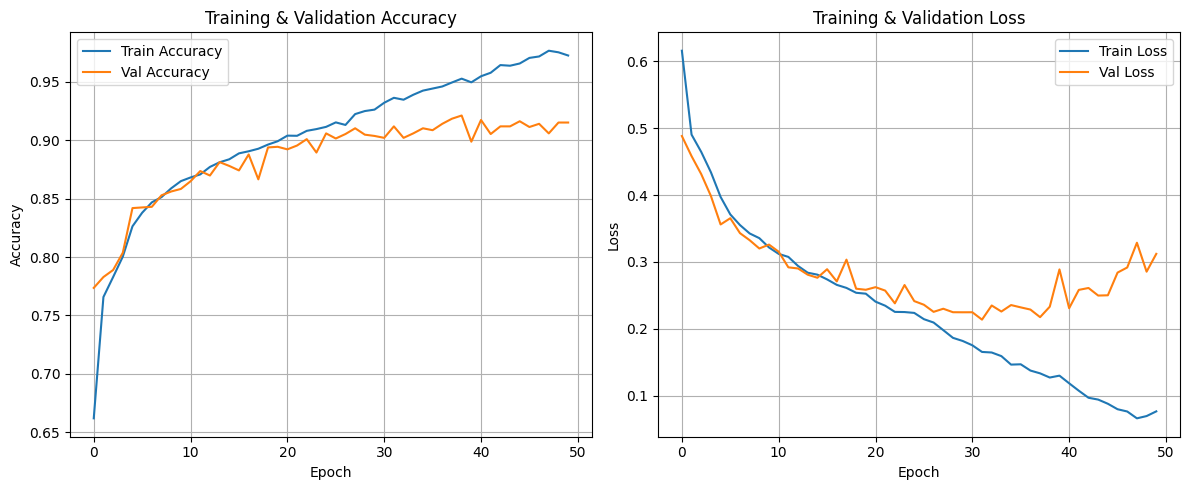

In [ ]:
# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
